pip install ccxt

## Code Overview

-------------------------------------------------------------------------------------------------------------
   - Section 1 : Library Import
   - Section 2 : Data Import
   - Section 3 : Data Plotting
   - Section 4 : Data Preprocessing
   - Section 5 : Model Defination
   - Section 6 : Model Training
   - Section 7 : Model Comparison with Entsoe data and Actual Data
-------------------------------------------------------------------------------------------------------------

###### Author : Soham Ekbote
###### Description : Python script for implementing LSTM using tensorflow for Bulgaria

##### =======================================================
### Section 1 : Library Import
##### =======================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import MinMaxScaler
import ccxt
ex = ccxt.binance()
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

C:\Users\soham\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\soham\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\soham\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


##### =======================================================
### Section 2 : Data Import
##### =======================================================

In [11]:
training_set = pd.read_csv('Datasets/BG-202001010000-202305010000.csv')

##### =======================================================
### Section 3 : Data plotting 
##### =======================================================

Text(0.5, 1.0, 'Renewable Energy Percentage')

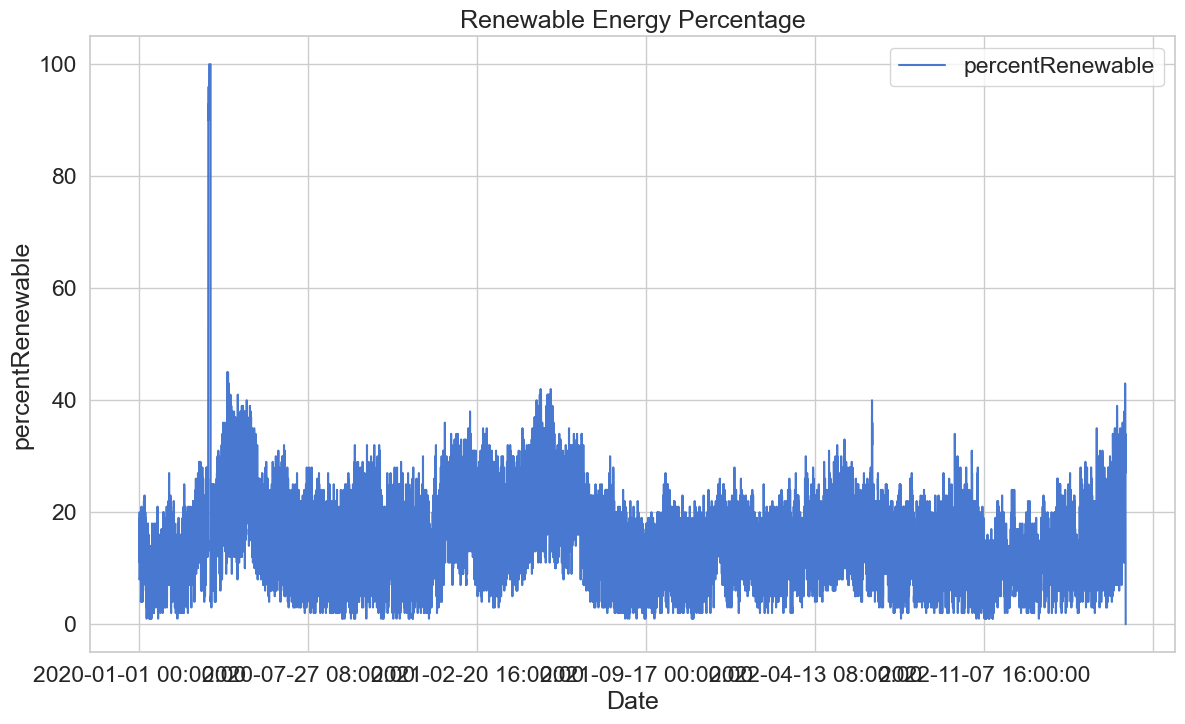

In [3]:
%matplotlib inline
#from pylab import rcParam

# Set the figure size for the plot (width=14 inches, height=8 inches)
mpl.rcParams['figure.figsize'] = 14, 8

# Set the style and palette for Seaborn
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Create a plot
# Plot 'percentRenewable' against 'startTime'
ax = training_set.plot(x='startTime', y='percentRenewable')

# Set the label for the x-axis
ax.set_xlabel('Date')

# Set the label for the y-axis
ax.set_ylabel('percentRenewable')

# Set the title for the plot
ax.set_title('Renewable Energy Percentage')


##### =======================================================
### Section 4 : Data Preprocessing 
##### =======================================================

In [4]:
# Import the StandardScaler from scikit-learn for data scaling
scaler = MinMaxScaler()

# Reshape the 'percentRenewable' values to a 2D array with a single column
reshape = training_set.percentRenewable.values.reshape(-1, 1)

# Use the StandardScaler to scale the data
scaled_data = scaler.fit_transform(reshape)

In [5]:
# Define the sequence length for creating input sequences
seq_len = 24

# Function to split the data into input sequences of length 'seq_len'
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

# Function to split the scaled data into training and testing sets
def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    
    # Determine the number of sequences for training based on the 'train_frac'
    n_train = int(sequences.shape[0] * train_frac)
    
    # Split sequences into input and output sets for training and testing
    x_train = sequences[:n_train, :-1, :]  # Input sequences for training
    y_train = sequences[:n_train, -1, :]    # Corresponding target values for training
    x_test = sequences[n_train:, :-1, :]    # Input sequences for testing
    y_test = sequences[n_train:, -1, :]     # Corresponding target values for testing
    
    return x_train, y_train, x_test, y_test

# Split the scaled data into training and testing sets
# using a 97% train fraction
x_train, y_train, x_test, y_test = get_train_test_sets(scaled_data, seq_len, train_frac=0.97)


##### =======================================================
### Section 5 : Model Defination
##### =======================================================

In [6]:
# Model parameters
input_size = 1      # Number of input features
hidden_size = 2    # Number of LSTM units in the hidden layer(s)
num_layers = 1     # Number of LSTM layers
num_classes = 1    # Number of output classes (assuming this is for regression)

# Training parameters
num_epochs = 2000         # Number of training epochs
learning_rate = 0.01     # Learning rate for model optimization

best_loss = float('inf')  # Initialize the best loss with positive infinity
patience_counter = 0     # Initialize a counter for early stopping
patience = 30            # Number of epochs to wait before early stopping if no improvement

# Create the LSTM model using the Sequential API
model = Sequential()

# Add a Bidirectional LSTM layer to the model
model.add(Bidirectional(
    LSTM(hidden_size, input_shape=(None, input_size), return_sequences=False)
))

# Add a Dense (fully connected) layer for output prediction
model.add(Dense(num_classes))


##### =======================================================
### Section 6 : Model Training
##### =======================================================

In [7]:
# Compile the LSTM model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
for epoch in range(num_epochs):
    # Train the model for one epoch
    history = model.fit(x_train, y_train, epochs=1, verbose=0)
    
    # Get the loss from the training history
    loss = history.history['loss'][0]
    
    # Print the training progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Step: {epoch+1}/{num_epochs}, Loss: {loss:.6f}")

    # Check if the current loss is better than the best seen so far
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
    else:
        # Increment the patience counter if there's no improvement in loss
        patience_counter += 1

    # Check if early stopping criteria are met
    if patience_counter >= patience:
        print(f"Early training stop. No improvement in loss for the last {patience} steps.")
        break



Step: 1/2000, Loss: 0.006380
Step: 101/2000, Loss: 0.000392
Step: 201/2000, Loss: 0.000388
Early training stop. No improvement in loss for the last 30 steps.


In [8]:
# Save and load the model
model.save('BG_final_60.h5')
from tensorflow.keras.models import load_model

model = load_model('BG_final_60.h5')

##### =========================================================================
### Section 7 : Model Result Comparison with Entsoe and Actual Data
##### =========================================================================

C:\Users\soham\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


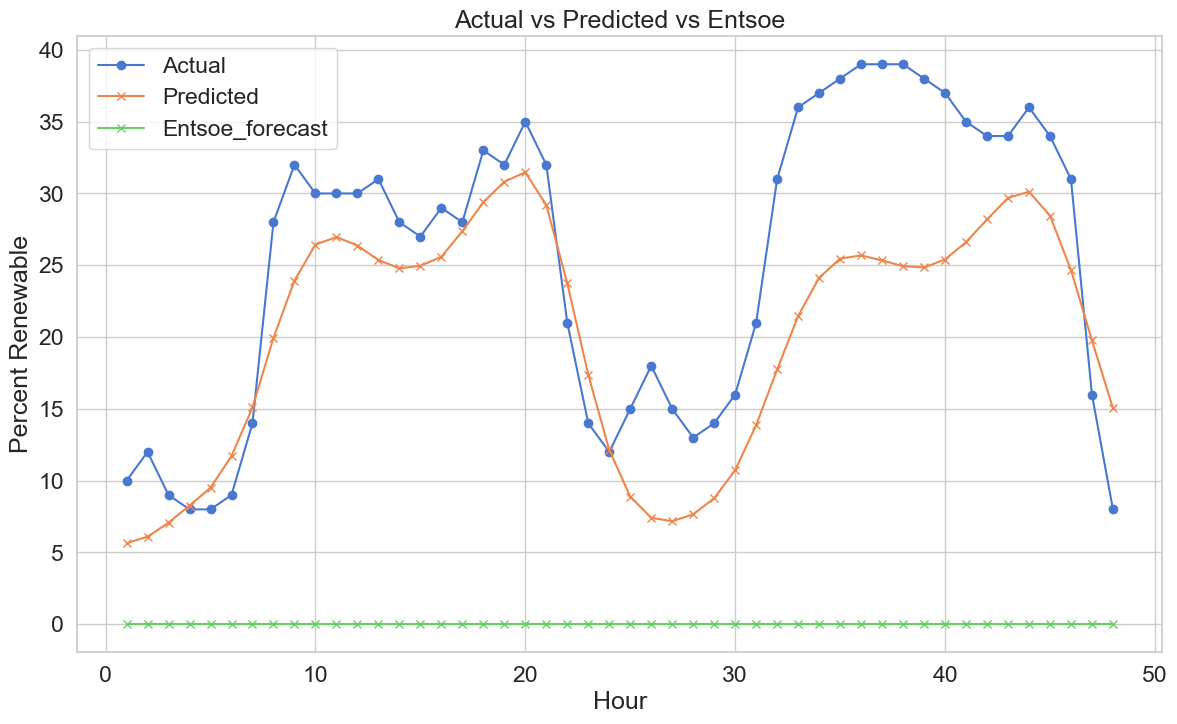

In [12]:
# Load ENTSOE forecast data from a CSV file
forecast = pd.read_csv('Datasets/BG-202001010000-202305010000-forecast.csv')

# Extract the 'percentRenewable' column from the forecast data
last_column_df_forecast = forecast[['percentRenewable']].copy()

# Calculate the number of data points for the 0.99 percent and 0.01 percent datasets
n_99_forecast = int(len(last_column_df_forecast) * 0.99)
n_01_forecast = int(len(last_column_df_forecast) * 0.01)

# Split the 'percentRenewable' column into 0.99 percent and 0.01 percent datasets
dataset_99_forecast = last_column_df_forecast.iloc[:n_99_forecast]
dataset_01_forecast = last_column_df_forecast.iloc[n_99_forecast:]

# Load the actual dataset
training_set1 = pd.read_csv('Datasets/BG-202001010000-202305010000.csv')

# Extract the 'percentRenewable' column from the actual dataset
last_column_df = training_set1[['percentRenewable']].copy()

# Calculate the number of data points for the 0.99 percent and 0.01 percent datasets
n_99 = int(len(last_column_df) * 0.99)
n_01 = int(len (last_column_df) * 0.01)

# Split the 'percentRenewable' column into 0.99 percent and 0.01 percent datasets
dataset_99 = last_column_df.iloc[:n_99]
dataset_01 = last_column_df.iloc[n_99:]

# Take the last 23 values from the 0.99 percent dataset
last_23_values = dataset_99.tail(23)

# Scale the last 23 values using the previously defined scaler
scaled_last_23_values = scaler.transform(last_23_values)

# Reshape the scaled last 23 values to match the input shape of the model
x_pred = scaled_last_23_values.reshape(1, 23, 1)

# Initialize a list to store the forecasted values
forecast_values = []

# Initialize the last 23 values with the last_23_values from the 0.99 percent dataset
last_23_values = last_23_values.values.flatten()

# Perform forecasting for the next 48 hours
for _ in range(48):
    # Scale the last 23 values using the MinMaxScaler
    scaled_last_23_values = scaler.transform(last_23_values.reshape(-1, 1))

    # Reshape the scaled last 23 values to match the input shape of the model
    x_pred = scaled_last_23_values[-23:].reshape(1, 23, 1)

    # Use the trained model to predict the next hour
    predicted_value = model.predict(x_pred)

    # Inverse transform the predicted value to the original scale
    predicted_value = scaler.inverse_transform(predicted_value)

    # Append the predicted value to the forecast_values list
    forecast_values.append(predicted_value[0][0])

    # Update the last 23 values by appending the predicted value
    last_23_values = np.append(last_23_values, predicted_value)

# Get the first 48 hours from the 0.01 percent dataset
actual_values_01 = dataset_01.head(48).values.flatten()
entsoe_values_01 = dataset_01_forecast.head(48).values.flatten()

# Create a list of hours from 1 to 48
hours = list(range(1, 49))

# Plot the graph of actual vs predicted values for the first 48 hours
plt.plot(hours, actual_values_01, label='Actual', marker='o')
plt.plot(hours, forecast_values[:48], label='Predicted', marker='x')
plt.plot(hours, entsoe_values_01, label='Entsoe_forecast', marker='x')
plt.xlabel('Hour')
plt.ylabel('Percent Renewable')
plt.title('Actual vs Predicted vs Entsoe')
plt.legend()
plt.show()
